# Deep Learning: Ex.7 - **Features visualization**



In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


---
In this question we will use a "VGG-like" model (similar to the one you trained in past exercises) that was pre-trained on the CIFAR-10 dataset. you will need to download the model and put it in your working directory.

This model consists of the following layers: 

 - input (32x32x3) -> (Conv -> Conv -> Pool) -> (Conv -> Conv -> Pool) -> (Conv -> Conv -> Pool) -> 2048-Dense -> 10-output
 
There are also some batch-normalization and dropout layers in between. All `Conv2D` layers use 3x3 kernels with `padding='same'`.

We will use the 10,000 validation images of the CIFAR-10 dataset for the following analysis.

In [ ]:
# download the pre-trained model:
!git clone https://github.com/rubinj/cifar_model.git

# load the model:
vgg16 = tf.keras.models.load_model('cifar_model/model.h5') 

for i,l in enumerate(vgg16.layers):
    print('%-5i' % i,
          '%-20s' % (l.name,),
          '%s' % (l.output_shape[1:],))

Cloning into 'cifar_model'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
0     conv2d               (32, 32, 32)
1     batch_normalization  (32, 32, 32)
2     conv2d_1             (32, 32, 32)
3     batch_normalization_1 (32, 32, 32)
4     max_pooling2d        (16, 16, 32)
5     dropout              (16, 16, 32)
6     conv2d_2             (16, 16, 64)
7     batch_normalization_2 (16, 16, 64)
8     conv2d_3             (16, 16, 64)
9     batch_normalization_3 (16, 16, 64)
10    max_pooling2d_1      (8, 8, 64)
11    dropout_1            (8, 8, 64)
12    conv2d_4             (8, 8, 128)
13    batch_normalization_4 (8, 8, 128)
14    conv2d_5             (8, 8, 128)
15    batch_normalization_5 (8, 8, 128)
16    max_pooling2d_2      (4, 4, 128)
17    dropout_2            (4, 4, 128)
18    flatten              (

In [ ]:
# download the cifar10 dataset:

from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

170508288/170498071 [==============================] - 6s 0us/step
x_test.shape =  (10000, 32, 32, 3)
y_test.shape =  (10000, 1)


---
### 1. Embedding of the feature space in 2-D (using PCA)

In this question we will use our pre-trained model as a smart feature-extractor.
To this aim, we will use its output from the `fc2` layer (the layer before the last one). This layer produces a 4096-D vector for any given image input of size (32,32,3).

- We will use this method, to extract a 4096-D features representation, for each of the 10,000 test images. (you can start with a smaller set of images, if computer resources are limited).

- Use PCA to to reduce the dimensionality of the features (from 4096-D to 2-D), and use a scatter plot to visualize all  samples in this 2-D space. Color the samples by their true label (use the `tab10` color map).



In [ ]:
features_extractor = keras.Model(inputs=vgg16.inputs, outputs=vgg16.layers[-2].output)

features = features_extractor.predict(x_test)
features.shape

(10000, 2048)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(features)

features_2D = pca.transform(features)
features_2D.shape

(10000, 2)

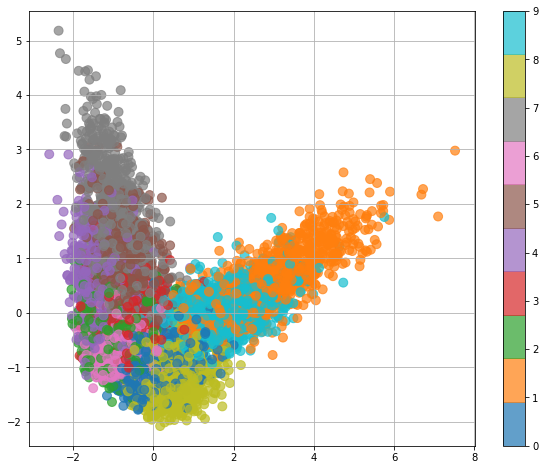

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(features_2D[:,0], features_2D[:,1], s=80, c=y_test, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.grid()
plt.show()

---
### 2. Embedding of the feature space in 2-D (using PCA + tSNE)

Usually, tSNE gives better results for this kind of task. The problem is that running tSNE on a large matrix (10,000 x 4,096), can take too long.

Therefore, we will first use PCA to reduce the dimensionality of the features: from 4096-D to 50-D.

Then, we will use tSNE to further reduce the dimensionality from 50-D to 2-D.

As before, use a scatter plot to visualize all  samples in this 2-D space. Color the samples by their true label (use the `tab10` color map).




In [ ]:
pca = PCA(n_components=50).fit(features)

features_2D = pca.transform(features)
features_2D.shape

(10000, 50)

In [ ]:
from sklearn.manifold import TSNE

features_2D = TSNE(n_components=2).fit_transform(features_2D)
features_2D.shape

(10000, 2)

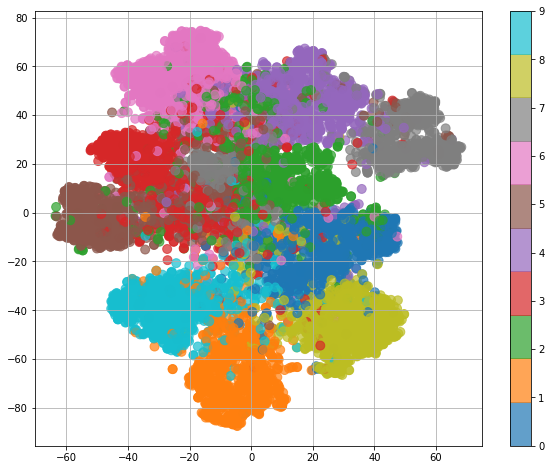

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(features_2D[:,0], features_2D[:,1], s=80, c=y_test, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.grid()
plt.show()

---
### 3. Maximally activating patches

In this question, we will explore the different filters along the pre-trained model.


- pick the 2nd conv layer in the model (`conv2d_1`), calculate its activation pattern for each of the 10,000 images. 
- pick the 1st filter (channel) in that layer (out of the 32 available), and look for the 6 highest activations there. (note: in class we picked the highest activation, here you need to sort them and pick the 6 highest.). for each of these highest activations, plot the corresponding patch that elicited that excited response.






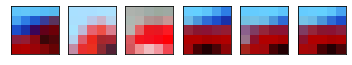

In [ ]:
activations_extractor = keras.Model(inputs=vgg16.inputs, outputs=vgg16.layers[2].output)

a = activations_extractor.predict(x_test)
a.shape

S = 1 # scale factor for (i,j)
P = 2 # padding
K = 5 # patch size: K x K

# pick one of the 32 filters
filter_id = 1
patches = []

idxes = np.argsort(a[:,:,:,filter_id],axis=None)[-6:] 
for idx in idxes:
  (img_idx, i, j) = np.unravel_index(idx, a.shape[:3])
  img = x_test[img_idx]
  img_padded = np.pad(img,((P,P),(P,P),(0,0)))
  patch = img_padded[S*i:S*i+K, S*j:S*j+K, :]
  patches.append(patch)

plt.figure(figsize=(6,8))
for i in range(6):
  plt.subplot(1,6,i+1)
  plt.imshow(patches[i])
  plt.xticks([])
  plt.yticks([])

- repeat the same process for 7 more filters (channels) in the same layer (`conv2d_1`). 

- plot 6 patches (maximally activating) for each of the 7 filters (total 6x8 patches, including the 1st filter from before).  

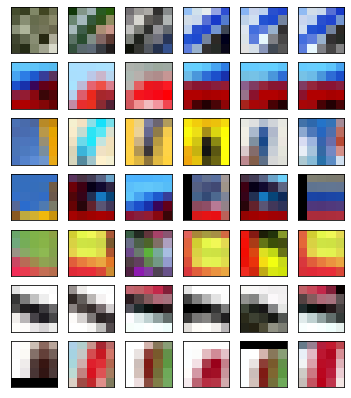

In [ ]:
patches = []
for f_idx in range(7):
  idxes = np.argsort(a[:,:,:,f_idx],axis=None)[-6:] 
  for idx in idxes:
          (img_idx, i, j) = np.unravel_index(idx, a.shape[:3])
          img = x_test[img_idx]
          img_padded = np.pad(img,((P,P),(P,P),(0,0))) 
          patch = img_padded[S*i:S*i+K, S*j:S*j+K, :]
          patches.append(patch)

plt.figure(figsize=(6,7))
for i in range(7*6):
  plt.subplot(7,6,i+1)
  plt.imshow(patches[i])
  plt.xticks([])
  plt.yticks([])

- Finally, repeat the whole process for two more layers in the model: `conv2d_2` and `conv2d_3`. For each of these two layers, pick 8 filters (channels), and find the 6 maximally activating patches for each filter.

Pay careful attention to the way you transform the index `(i,j)` in the activation layer to the correct patch in the image.. 

You should get results similar to the ones in the presentation slides.

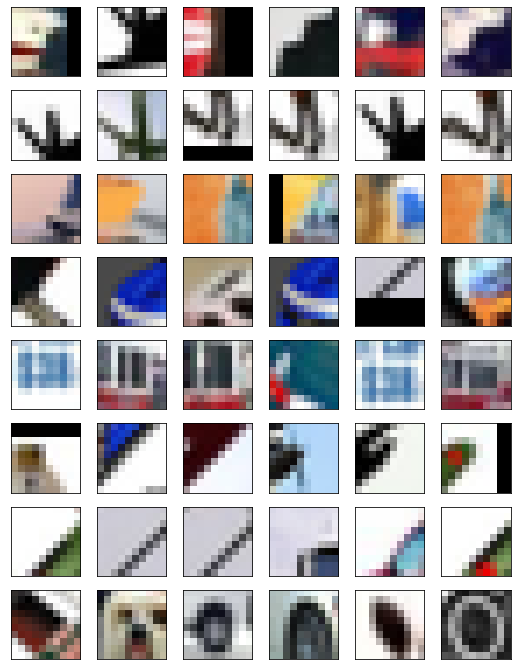

In [ ]:
activations_extractor = keras.Model(inputs=vgg16.inputs, outputs=vgg16.layers[6].output)

a = activations_extractor.predict(x_test)
a.shape

S = 2 # scale factor for (i,j)
P = 4 # padding
K = 10 # patch size: K x K

patches = []
for f_idx in range(8): # pick 8 filters
  idxes = np.argsort(a[:,:,:,f_idx],axis=None)[-6:] # 6 highest responses
  for idx in idxes:
        (img_idx, i, j) = np.unravel_index(idx, a.shape[:3])
        img = x_test[img_idx]
        img_padded = np.pad(img,((P,P),(P,P),(0,0))) # pad the rows & columns
        patch = img_padded[S*i:S*i+K, S*j:S*j+K, :]
        patches.append(patch)

plt.figure(figsize=(9,12))
for i in range(8*6):
  plt.subplot(8,6,i+1)
  plt.imshow(patches[i])
  plt.xticks([])
  plt.yticks([])


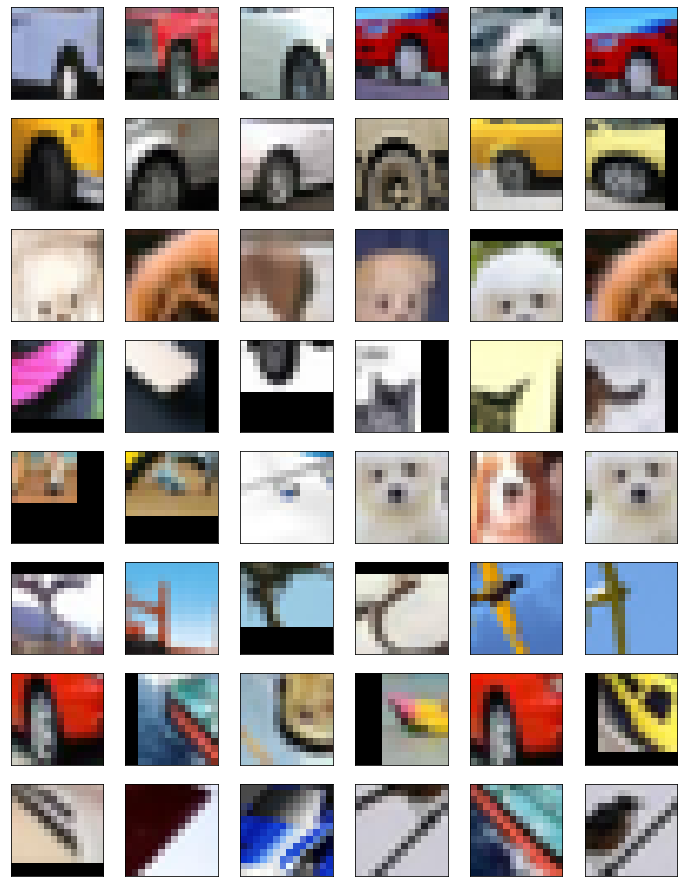

In [ ]:
activations_extractor = keras.Model(inputs=vgg16.inputs, outputs=vgg16.layers[8].output)

a = activations_extractor.predict(x_test)
a.shape

S = 2 # scale factor for (i,j)
P = 6 # padding
K = 14 # patch size: K x K

patches = []
for f_idx in range(8): 
  idxes = np.argsort(a[:,:,:,f_idx],axis=None)[-6:] 
  for idx in idxes:
        (img_idx, i, j) = np.unravel_index(idx, a.shape[:3])
        img = x_test[img_idx]
        img_padded = np.pad(img,((P,P),(P,P),(0,0)))
        patch = img_padded[S*i:S*i+K, S*j:S*j+K, :]
        patches.append(patch)

plt.figure(figsize=(12,16))
for i in range(8*6):
  plt.subplot(8,6,i+1)
  plt.imshow(patches[i])
  plt.xticks([])
  plt.yticks([])
